In [170]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [171]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [172]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, select, desc

In [173]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [174]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [175]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [176]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [177]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [178]:
#Creating inspector element
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [181]:
#Checking column names
columns_measurement = inspector.get_columns('measurement')
for cols in columns_measurement:
    print(cols["name"], cols["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [182]:
connection = engine.connect()
select_query = select([measurement])
result = connection.execute(select_query).fetchall()
result


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', 0.0, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397'

In [138]:
session.execute("UPDATE measurement SET prcp=0.0 WHERE prcp is Null")

In [139]:
session.commit()

In [140]:
# Find the most recent date in the data set.
latest_date=session.query(func.max(measurement.date)).all()
latest_date=latest_date[0][0]
latest_date

'2017-08-23'

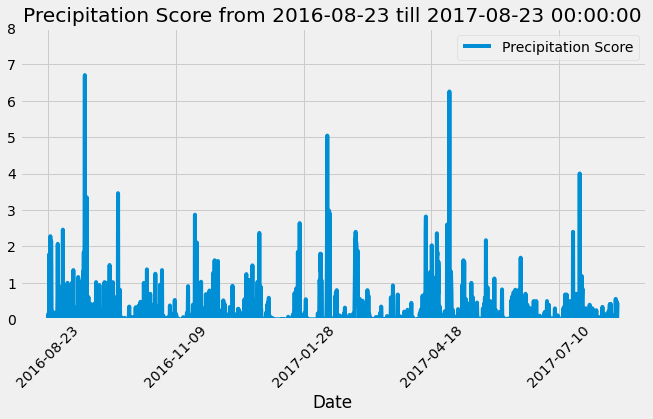

In [141]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_format = "%Y-%m-%d"
latest_date = dt.datetime.strptime(latest_date, date_format)
year_gap = latest_date - dt.timedelta(days=365)
start_date = year_gap.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date,measurement.prcp).filter(measurement.date <= latest_date).filter(measurement.date >= start_date).order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_scores).rename(columns={'date':'Date','prcp':'Precipitation Score'})


# Sort the dataframe by date
prcp_df.set_index('Date',inplace=True)
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10,5),ylim=(0,8),title=f'Precipitation Score from {start_date} till {latest_date}',
            label="Precipitation",rot=45)
plt.show()

In [142]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation Score
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [143]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(station).count()
stations

9

In [144]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
top_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()
top_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [147]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).first()


most_active_info = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == most_active_station[0]).all()
most_active_info

[(54.0, 85.0, 71.66378066378067)]

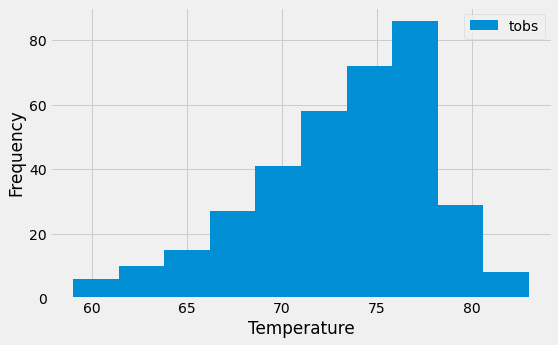

In [160]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = most_active_station[0]
most_active_station_id
most_active_station_temps = session.query(measurement.tobs).filter(measurement.station == most_active_station_id).filter(
                                          measurement.date <= latest_date).filter(measurement.date >= start_date).order_by(measurement.date)
temps_df = pd.DataFrame(most_active_station_temps)

temps_df.plot(kind='hist',figsize=(8,5))
plt.xlabel("Temperature")
plt.legend()
plt.show()

# Close Session

In [161]:
# Close Session
session.close()